In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import vgg16_bn
import PIL
import imageio
from superres import *

In [2]:
img_data = Path('/scratch/bpho/datasets/mitomovies_001/')
model_path = Path('/scratch/bpho/models')

In [3]:
def get_src(size=128):
    hr_tifs = img_data/f'roi_hr_{size}'
    lr_tifs = img_data/f'roi_lr_up_{size}'

    def map_to_hr(x):
        hr_name = x.relative_to(lr_tifs)
        return hr_tifs/hr_name
    print(lr_tifs)
    src = (ImageImageList
            .from_folder(lr_tifs)
            .split_by_folder()
            .label_from_func(map_to_hr))
    return src

def _gaussian_noise_gray(x, gauss_sigma=1.):
    c,h,w = x.shape
    noise = torch.zeros((1,h,w))
    noise.normal_(0, gauss_sigma)
    img_max = np.minimum(1.1 * x.max(), 1.)
    x = np.minimum(np.maximum(0,x+noise.repeat((3,1,1))), img_max)
    return x

gaussian_noise_gray = TfmPixel(_gaussian_noise_gray)


def get_data(bs, size, tile_size=None, noise=None):
    if tile_size is None: tile_size = size
    src = get_src(tile_size)
    
    tfms = [[rand_crop(size=size)],[]]
    tfms = get_transforms(flip_vert=True, max_zoom=2)
    y_tfms = [[t for t in tfms[0]], [t for t in tfms[1]]]
    if not noise is None:
        tfms[0].append(gaussian_noise_gray(gauss_sigma=noise))
    data = (src
            .transform(tfms, size=size)
            .transform_y(y_tfms, size=size)
            .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data


In [4]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

In [5]:
base_loss = F.l1_loss

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [6]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [7]:
bs = 64
size = 128
data = get_data(bs, size)
data

/scratch/bpho/datasets/mitomovies_001/roi_lr_up_128


ImageDataBunch;

Train: LabelList
y: ImageItemList (3800 items)
[Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128)]...
Path: /scratch/bpho/datasets/mitomovies_001/roi_lr_up_128
x: ImageImageList (3800 items)
[Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32)]...
Path: /scratch/bpho/datasets/mitomovies_001/roi_lr_up_128;

Valid: LabelList
y: ImageItemList (1900 items)
[Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128)]...
Path: /scratch/bpho/datasets/mitomovies_001/roi_lr_up_128
x: ImageImageList (1900 items)
[Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32)]...
Path: /scratch/bpho/datasets/mitomovies_001/roi_lr_up_128;

Test: None

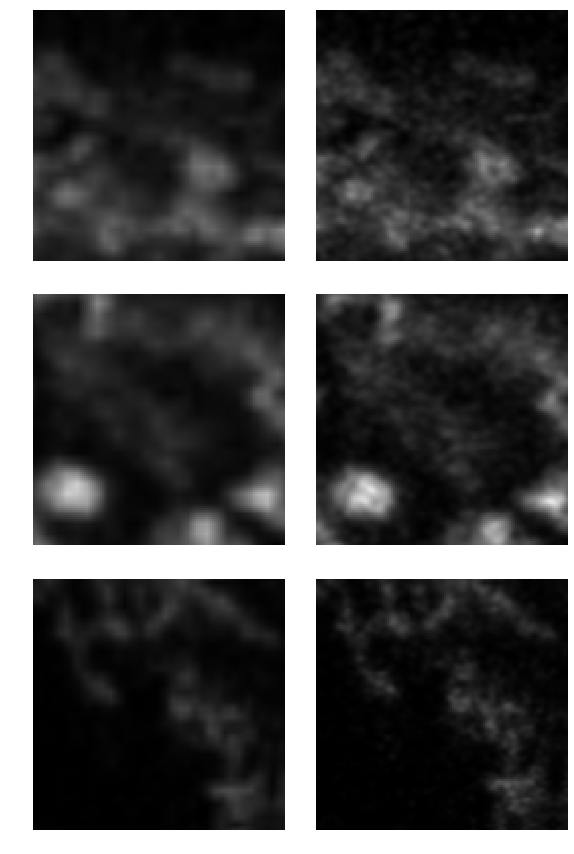

In [8]:
data.show_batch(3)

In [9]:
arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

11917

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


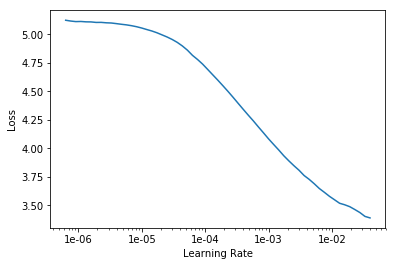

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
lr = 1e-3

In [12]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    num_rows = min(learn.data.batch_size, 3)
    learn.show_results(rows=num_rows, imgsize=5)

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,2.383071,1.590968,0.060963,0.525129,12.157812,0.164532,0.210033,0.206866,0.052279,0.425088,0.492530,0.039640
2,1.594214,1.328128,0.059908,0.521976,12.235466,0.158043,0.198670,0.180892,0.045457,0.318967,0.391180,0.034918
3,1.375698,1.276436,0.058707,0.523191,12.321881,0.166708,0.193930,0.177093,0.044741,0.283120,0.376200,0.034645
4,1.337502,1.384725,0.061511,0.535118,12.119446,0.164868,0.198066,0.182774,0.047706,0.340889,0.412383,0.038039
5,1.296288,1.281487,0.059849,0.528737,12.239209,0.165765,0.193019,0.173773,0.043995,0.299291,0.371225,0.034419
6,1.248551,1.211202,0.064489,0.526767,11.913811,0.170120,0.188711,0.167775,0.042239,0.261006,0.348389,0.032962
7,1.225379,1.260096,0.059312,0.533769,12.278606,0.163514,0.190500,0.170585,0.043666,0.292881,0.364581,0.034370
8,1.210106,1.251943,0.060214,0.524216,12.211747,0.171943,0.191752,0.170976,0.042940,0.279092,0.361919,0.033320
9,1.192697,1.161727,0.057337,0.538580,12.426601,0.151238,0.186444,0.164360,0.041114,0.247806,0.338811,0.031955
10,1.165700,1.138812,0.057464,0.531796,12.417436,0.149026,0.186183,0.163523,0.040871,0.233880,0.333625,0.031703


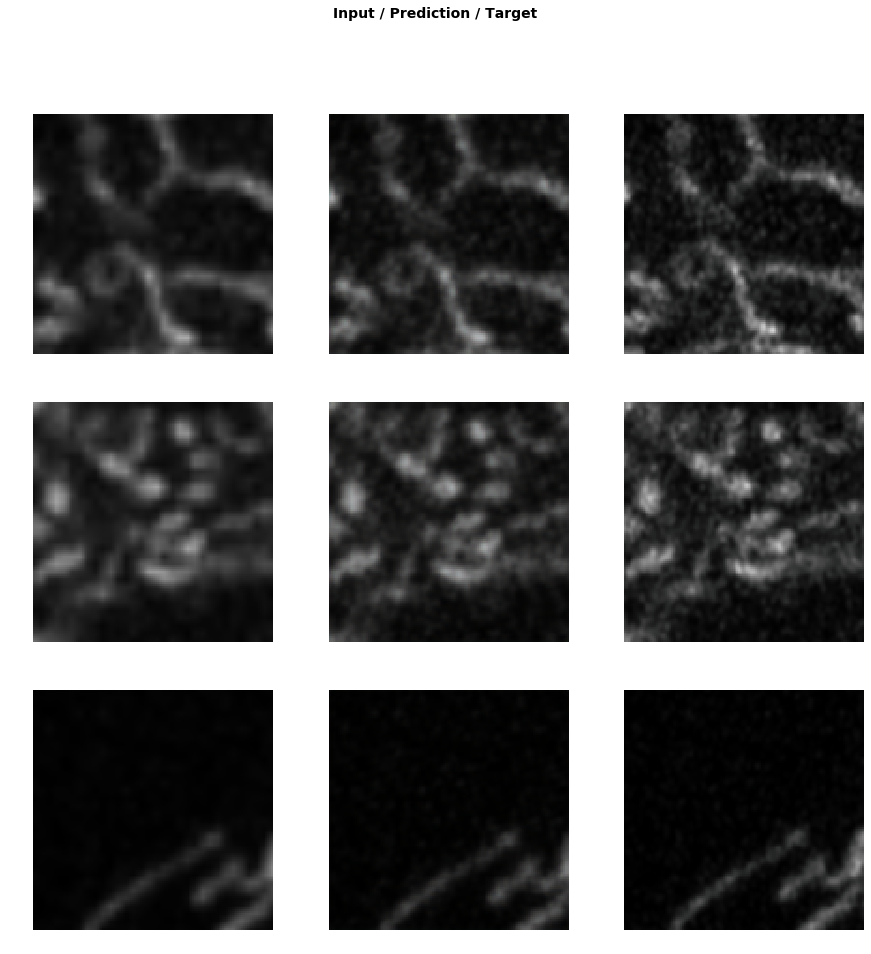

In [13]:
do_fit('mitomovies_001_unet.0', slice(lr*10))

In [14]:
learn.unfreeze()

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,1.133936,1.131041,0.057392,0.532255,12.422841,0.148980,0.185975,0.163072,0.040745,0.229081,0.331579,0.031609
2,1.131411,1.133537,0.056685,0.533209,12.476739,0.148155,0.185756,0.163166,0.040787,0.232082,0.331919,0.031672
3,1.128751,1.139625,0.057060,0.533588,12.448139,0.148531,0.185835,0.163350,0.041054,0.235118,0.333811,0.031926
4,1.128424,1.126346,0.055426,0.541777,12.574197,0.146455,0.184218,0.162204,0.040501,0.230690,0.330849,0.031429
5,1.127944,1.132946,0.055960,0.537654,12.532693,0.147135,0.184936,0.162467,0.040626,0.234126,0.332095,0.031560
6,1.127570,1.119944,0.055514,0.535465,12.567401,0.146633,0.184435,0.161563,0.040395,0.227608,0.327887,0.031422
7,1.124707,1.141354,0.055726,0.535186,12.550905,0.147199,0.185332,0.163263,0.040771,0.239165,0.333988,0.031638
8,1.122091,1.116646,0.056214,0.535438,12.512828,0.147308,0.184402,0.161003,0.040215,0.225680,0.326748,0.031291
9,1.125149,1.101611,0.055286,0.536916,12.585181,0.146503,0.183743,0.160081,0.039956,0.217011,0.323238,0.031078
10,1.119803,1.110570,0.055203,0.536116,12.591773,0.146239,0.184022,0.160307,0.040018,0.224335,0.324501,0.031147


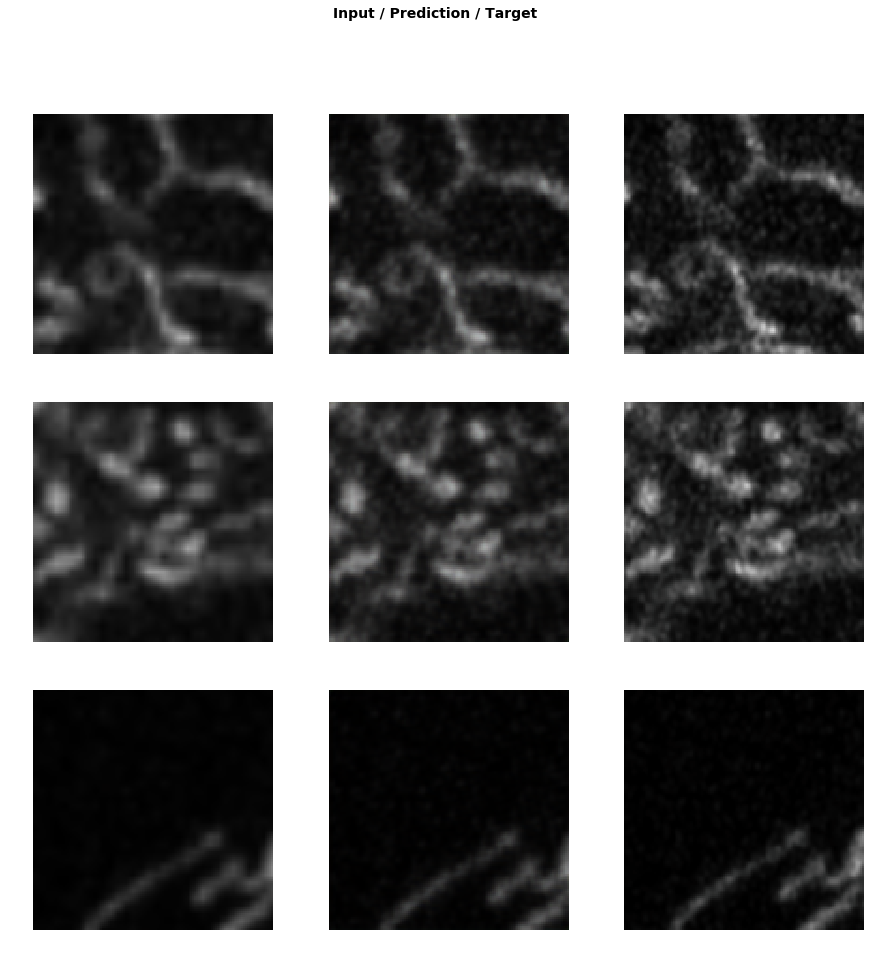

In [15]:
do_fit('mitomovies_001_unet.1', slice(1e-5,lr))

In [16]:
bs = 32
size = 256
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('mitomovies_001_unet.1')

/scratch/bpho/datasets/mitomovies_001/roi_lr_up_256


epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,0.731530,0.753942,0.042282,0.506230,13.761560,0.124310,0.171828,0.134412,0.025919,0.139721,0.144836,0.012917
2,0.722797,0.749568,0.041759,0.509596,13.815566,0.123616,0.171313,0.134954,0.026028,0.137021,0.143735,0.012899
3,0.719483,0.749924,0.042394,0.507616,13.750098,0.124350,0.171577,0.134835,0.025897,0.137317,0.143140,0.012809
4,0.719408,0.762540,0.043570,0.504191,13.631623,0.125576,0.172793,0.135269,0.026151,0.144162,0.145627,0.012964
5,0.721689,0.754320,0.042401,0.508171,13.749217,0.123998,0.171675,0.135159,0.025994,0.140916,0.143708,0.012872
6,0.717004,0.733533,0.043684,0.499453,13.620197,0.125963,0.172330,0.134553,0.025916,0.123130,0.138784,0.012858
7,0.720687,0.719411,0.043692,0.498998,13.619563,0.126190,0.172113,0.133426,0.025827,0.113242,0.135890,0.012722
8,0.718745,0.735471,0.043111,0.503013,13.678029,0.125490,0.171743,0.134880,0.025917,0.125118,0.139529,0.012793
9,0.715555,0.764215,0.043144,0.495790,13.673783,0.125977,0.173544,0.136025,0.025963,0.144305,0.145557,0.012844
10,0.708738,0.734098,0.042441,0.505231,13.745872,0.124298,0.171236,0.134372,0.025814,0.126283,0.139341,0.012754


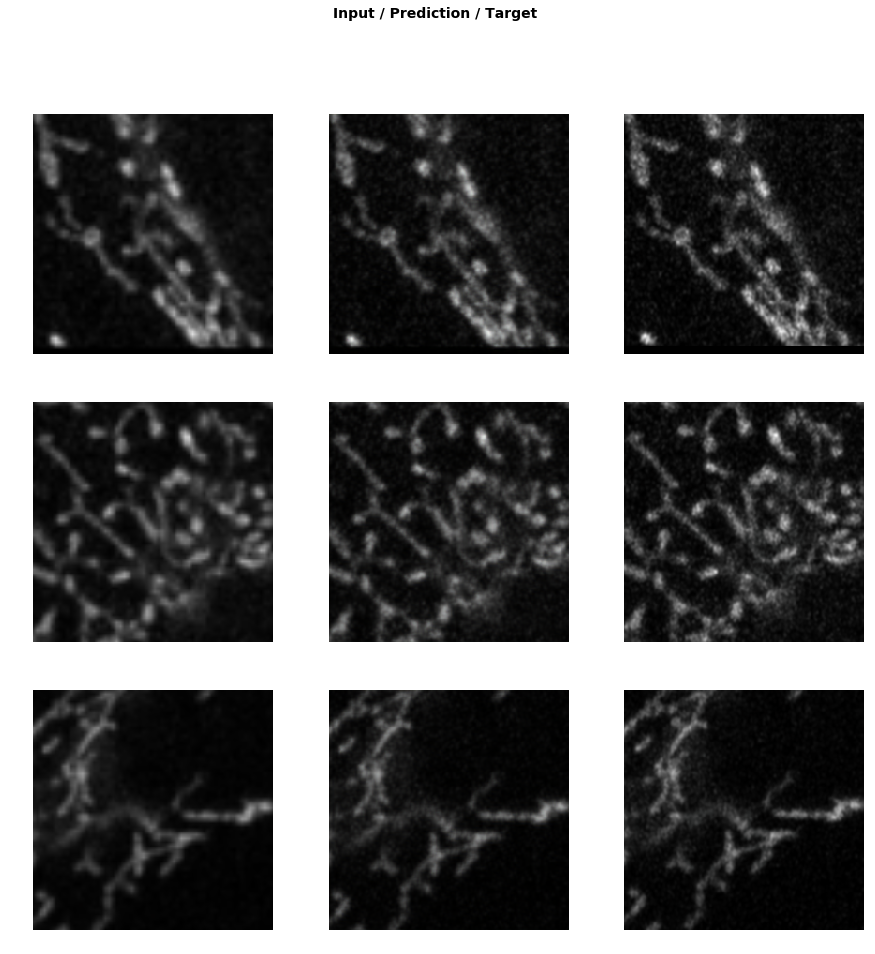

In [17]:
do_fit('mitomovies_001_unet.2', lr)

In [18]:
learn.unfreeze()

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,0.704778,0.727523,0.041977,0.506346,13.793682,0.123828,0.170878,0.134257,0.025787,0.121973,0.138096,0.012705
2,0.707888,0.728671,0.042030,0.508723,13.788424,0.123816,0.170772,0.134321,0.025824,0.122586,0.138633,0.012719
3,0.702905,0.752663,0.042380,0.500668,13.751536,0.124544,0.172285,0.135456,0.026005,0.138657,0.142844,0.012873
4,0.701713,0.745333,0.044504,0.490956,13.539064,0.127323,0.173611,0.134953,0.025805,0.129954,0.140949,0.012737
5,0.703484,0.725483,0.042143,0.502497,13.776141,0.124284,0.171272,0.133974,0.025666,0.119881,0.137738,0.012667
6,0.700981,0.752378,0.042661,0.502511,13.723189,0.125169,0.172744,0.135921,0.026078,0.136280,0.143309,0.012875
7,0.700284,0.710875,0.041546,0.505501,13.838330,0.124190,0.170956,0.133360,0.025489,0.108317,0.135960,0.012603
8,0.698013,0.715621,0.040650,0.509369,13.932850,0.122331,0.170070,0.133661,0.025721,0.113672,0.137461,0.012704
9,0.699798,0.746790,0.044684,0.498661,13.523632,0.127036,0.173166,0.135331,0.026091,0.130699,0.141598,0.012870
10,0.686311,0.716975,0.040465,0.512947,13.953599,0.121810,0.169503,0.133335,0.025679,0.116878,0.137100,0.012671


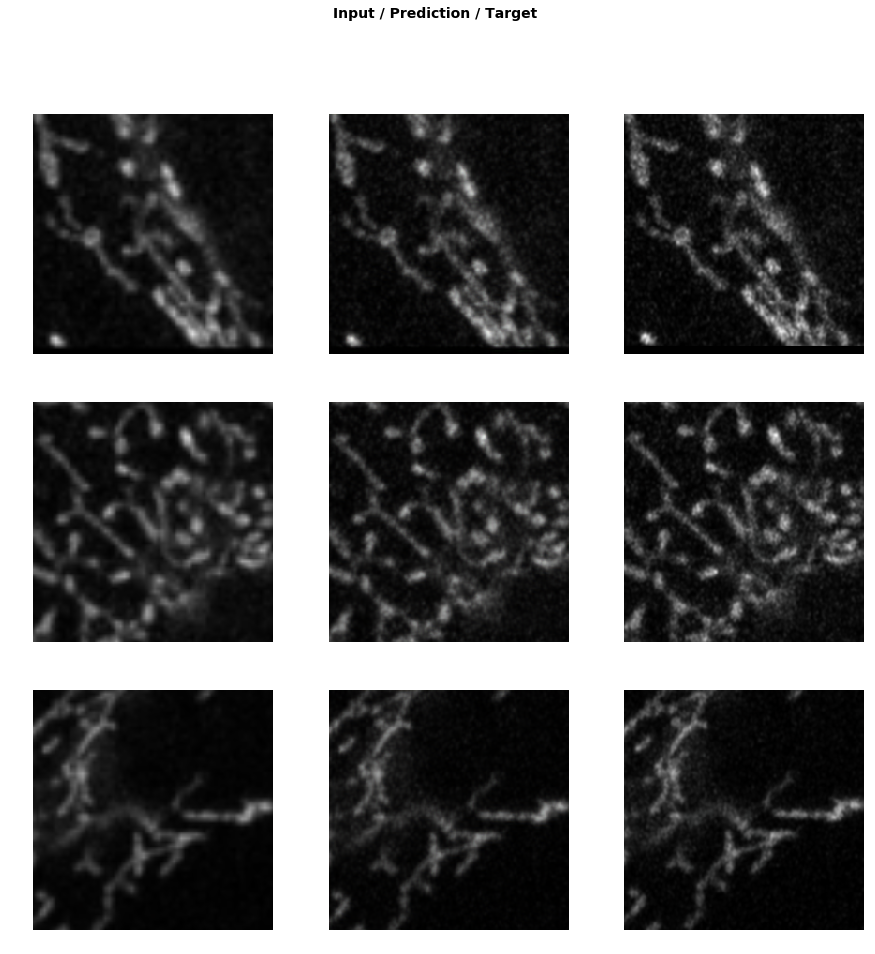

In [19]:
do_fit('mitomovies_001_unet.3', slice(1e-5,lr))

In [ ]:
bs = 4
size = 512
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('mitomovies_001_unet.3')

In [ ]:
do_fit('mitomovies_001_unet.4', lr)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('mitomovies_001_unet.5', slice(1e-5,lr), cycle_len=50)

In [ ]:
bs = 2
size = 1024
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('mitomovies_001_unet.5')

In [ ]:
do_fit('mitomovies_001_unet.6', lr)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('mitomovies_001_unet.7', slice(1e-5,lr), cycle_len=50)

In [ ]:
bs = 2
size = 1024
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('mitomovies_001_unet.6')

In [ ]:
learn.unfreeze()
do_fit('mitomovies_001_unet.8', slice(1e-6,1e-5), cycle_len=10)

In [26]:
!ls /scratch/bpho/models

mitomovies_001_unet.0.pth    paired_001_unet.0.pth
mitomovies_001_unet.1.pth    paired_001_unet.1.pth
mitomovies_001_unet.2.pth    paired_001_unet.2.pth
mitomovies_001_unet.3.pkl    paired_001_unet.3.pth
mitomovies_001_unet.3.pth    paired_001_unet.4.pth
movies_001.0.pth	     paired_001_unet.5.pth
movies_001.1.pth	     paired_001_unet.6.pth
movies_002_unet.0.pth	     paired_001_unet.7.pth
movies_002_unet.1.pth	     paired_001_unet.8.pkl
movies_002_unet.2.pth	     paired_001_unet.8.pth
movies_002_unet.3.pth	     paired_001_unet_lr2hr.0.pth
movies_002_unet.4.pth	     paired_001_unet_lr2hr.1.pth
movies_002_unet.5.pth	     paired_001_unet_lr2hr.2.pth
movies_002_unet-noise.0.pth  paired_001_unet_lr2hr.3.pkl
movies_002_unet-noise.1.pth  paired_001_unet_lr2hr.3.pth
movies_002_unet-noise.2.pth  paired_001_unet_lr2hr.4.pth
movies_002_unet-noise.3.pth  paired_001_unet_lr2hr.5.pth
movies_002_unet-noise.4.pth  paired_001_unet_lr2hr.6.pkl
movies_002_unet-noise.5.pth  paired_001_unet_lr2hr.6.pth
mov

In [27]:
movie_files = list(Path('/scratch/bpho/datasets/movies_001/test').glob('*.czi'))

In [28]:
fn = movie_files[0]

In [ ]:
with czifile.CziFile(fn) as czi_f:
    proc_axes, proc_shape = get_czi_shape_info(czi_f)
    channels = proc_shape['C']
    depths = proc_shape['Z']
    times = proc_shape['T']
    x,y = proc_shape['X'], proc_shape['Y']
    data = czi_f.asarray()
    preds = []
    origs = []
    idx = build_index(proc_axes, {'T': 0, 'C': 0, 'Z':0, 'X':slice(0,x),'Y':slice(0,y)})
    img = data[idx].astype(np.float32)
    img /= (img.max() * 1.5)

In [20]:
def image_from_tiles(learn, img, tile_sz=128, scale=4):
    pimg = PIL.Image.fromarray((img*255).astype(np.uint8), mode='L').convert('RGB')
    cur_size = pimg.size
    new_size = (cur_size[0]*scale, cur_size[1]*scale)
    in_img = Image(pil2tensor(pimg.resize(new_size, resample=PIL.Image.BICUBIC),np.float32).div_(255))
    c, w, h = in_img.shape
    
    in_tile = torch.zeros((c,tile_sz,tile_sz))
    out_img = torch.zeros((c,w,h))
    
    for x_tile in range(math.ceil(w/tile_sz)):
        for y_tile in range(math.ceil(h/tile_sz)):
            x_start = x_tile

            x_start = x_tile*tile_sz
            x_end = min(x_start+tile_sz, w)
            y_start = y_tile*tile_sz
            y_end = min(y_start+tile_sz, h)
            
            
            in_tile[:,0:(x_end-x_start), 0:(y_end-y_start)] = in_img.data[:,x_start:x_end, y_start:y_end]
            
            out_tile,_,_ = learn.predict(Image(in_tile))

            out_x_start = x_start
            out_x_end = x_end
            out_y_start = y_start
            out_y_end = y_end

            #print("out: ", out_x_start, out_y_start, ",", out_x_end, out_y_end)
            in_x_start = 0
            in_y_start = 0
            in_x_end = x_end-x_start
            in_y_end = y_end-y_start
            #print("tile: ",in_x_start, in_y_start, ",", in_x_end, in_y_end)
           
            out_img[:,out_x_start:out_x_end, out_y_start:out_y_end] = out_tile.data[:,
                                                                                  in_x_start:in_x_end, 
                                                                                  in_y_start:in_y_end]
    return out_img


In [56]:
def czi_predict_movie(learn, czi_in, orig_out='orig.tif', pred_out='pred.tif', size=128):
    with czifile.CziFile(czi_in) as czi_f:
        proc_axes, proc_shape = get_czi_shape_info(czi_f)
        channels = proc_shape['C']
        depths = proc_shape['Z']
        times = proc_shape['T']
        x,y = proc_shape['X'], proc_shape['Y']
        data = czi_f.asarray()
        preds = []
        origs = []
        img_max = None
        for t in progress_bar(list(range(times))):
            idx = build_index(proc_axes, {'T': t, 'C': 0, 'Z':0, 'X':slice(0,x),'Y':slice(0,y)})
            img = data[idx].astype(np.float32)
            if img_max is None: img_max = img.max() * 1.0
            img /= img_max
            out_img = image_from_tiles(learn, img, tile_sz=size).permute([1,2,0])
            pred = (out_img[None]*255).cpu().numpy().astype(np.uint8)
            preds.append(pred)
            orig = (img[None]*255).astype(np.uint8)
            origs.append(orig)

        all_y = np.concatenate(preds)
        #print(all_y.shape)
        all_y = all_y.mean(axis=3).astype(np.uint8) # cuz black and white
        imageio.mimwrite(pred_out, all_y) #, fps=30, macro_block_size=None) # for mp4
        
        #imageio.mimwrite(pred_out, all_y, fps=30, macro_block_size=None) # for mp4
        all_y = np.concatenate(origs)
        #print(all_y.shape)
        imageio.mimwrite(orig_out, all_y) #, fps=30, macro_block_size=None)
        #imageio.mimwrite(orig_out, all_y, fps=30, macro_block_size=None)


In [57]:
bs=1
size=1024
scale = 4

data = get_data(bs, size, tile_size=512)

wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()
learn = learn.load('mitomovies_001_unet.3')


/scratch/bpho/datasets/mitomovies_001/roi_lr_up_512


In [24]:
learn.export(model_path/'mitomovies_001_unet.3.pkl')
learn = load_learner(model_path, 'mitomovies_001_unet.3.pkl')

/home/fredmonroe/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
for fn in movie_files:
    pred_name = f'{fn.stem}_pred.tif' # .tif?
    orig_name = f'{fn.stem}_orig.tif'
    czi_predict_movie(learn, fn, size=size, orig_out=orig_name, pred_out=pred_name )

In [ ]:
learn.pred_batch()

In [46]:
%debug

> /home/fredmonroe/anaconda3/lib/python3.7/site-packages/imageio/core/format.py(224)__init__()
    222             self._request = request
    223             # Open the reader/writer
--> 224             self._open(**self.request.kwargs.copy())
    225 
    226         @property

ipdb> self._open??
*** SyntaxError: invalid syntax
ipdb> self._open
<bound method TiffFormat.Writer._open of <imageio.plugins.tifffile.TiffFormat.Writer object at 0x7f158483e908>>
ipdb> self._open.__dict__
{}
ipdb> s


In [50]:
w = imageio.get_writer('foo.tif')

In [52]:
w._open??